# Real dataset evaluation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [2]:
experiments_dir = '../../experiments/real_dataset_attack'
datasets = ['communities_and_crime_v2', 'fifa19_v2', 'musk']
seeds = [13315092, 21081788, 26735830, 35788921, 56755036, 56882282, 65682867, 91090292, 93410762, 96319575]
nbrs_bins = [3, 5]

In [3]:
def load_results(experiments_dir, dataset, shadow_model_type, meta_model_type, seeds, nbr_bins):
    if dataset in [ 'fifa19', 'fifa19_v2' ]:
        nbr_data_samples = 2000
    else:
        nbr_data_samples = 1000
    if dataset in ['communities_and_crime_v2', 'fifa19_v2' ]:
        test_sizes = '_tts-0.33333_sts-0'
    else:
        test_sizes = ''
    paths = [f'{experiments_dir}/{dataset}/cols-4/nmb-100/sr-{seed}' + 
             f'_nt-100_ns-5000_nds-{nbr_data_samples}{test_sizes}_ndsbb-100_smt-{shadow_model_type}_mmt-{meta_model_type}' +
             f'_nb-{nbr_bins}_sgf--1.pickle' 
             for seed in seeds]
    results = []
    for path in paths:
        if not os.path.exists(path):
            continue
        with open(path, 'rb') as f:
            result = pickle.load(f)
            if shadow_model_type == 'mlptorch' and not result['done']:
                continue
        results.append(result)
    print(f'\nFound {len(results)} results.')
    return results

In [4]:
for nbr_bins in nbrs_bins:
    print(f'\nB={nbr_bins} bins')
    for dataset in datasets:
        print(f'\nDataset={dataset}')
        logreg_results = load_results(experiments_dir, dataset, 'logreg', 'logreg', seeds, nbr_bins) 
        # Majority baseline
        accs_maj = []
        for result in logreg_results:
            target_labels = result['target_labels']
            count_per_class = np.array([np.sum(target_labels==b) for b in range(nbr_bins)])
            accs_maj.append(np.max(count_per_class)/len(target_labels))
        print(f'Accuracy (majority baseline): {np.mean(accs_maj):.3f} +- {np.std(accs_maj):.3f}')
        for mi, method in enumerate(['uniform_prior_empirical', 'model_predictions']):
            accs = [result['accuracy'][method] for result in logreg_results]
            if mi == 1:
                print(f'Accuracy (LR + {method}): {np.mean(accs):.3f} +- {np.std(accs):.3f}')
            else:
                print(f'Accuracy ({method}): {np.mean(accs):.3f} +- {np.std(accs):.3f}')   
        mlp_results = load_results(experiments_dir, dataset, 'mlptorch', 'mlptorch', seeds, nbr_bins) 
        accs = [result['accuracy']['model_predictions'] for result in mlp_results]
        print(f'Accuracy (MLPTorch + model predictions): {np.mean(accs):.3f} +- {np.std(accs):.3f}')


B=3 bins

Dataset=communities_and_crime_v2

Found 10 results.
Accuracy (majority baseline): 0.736 +- 0.027
Accuracy (uniform_prior_empirical): 0.736 +- 0.027
Accuracy (LR + model_predictions): 0.860 +- 0.036

Found 10 results.
Accuracy (MLPTorch + model predictions): 0.756 +- 0.040

Dataset=fifa19_v2

Found 10 results.
Accuracy (majority baseline): 0.571 +- 0.044
Accuracy (uniform_prior_empirical): 0.602 +- 0.050
Accuracy (LR + model_predictions): 0.912 +- 0.036

Found 10 results.
Accuracy (MLPTorch + model predictions): 0.788 +- 0.045

Dataset=musk

Found 10 results.
Accuracy (majority baseline): 0.678 +- 0.056
Accuracy (uniform_prior_empirical): 0.678 +- 0.056
Accuracy (LR + model_predictions): 0.820 +- 0.032

Found 10 results.
Accuracy (MLPTorch + model predictions): 0.563 +- 0.062

B=5 bins

Dataset=communities_and_crime_v2

Found 10 results.
Accuracy (majority baseline): 0.551 +- 0.023
Accuracy (uniform_prior_empirical): 0.276 +- 0.032
Accuracy (LR + model_predictions): 0.706 +- 

## Results for different discretizations of the one-way marginals

In [5]:
def load_marginal_bins_results(experiments_dir, seeds, nbr_marginal_bins):
    paths = [f'{experiments_dir}/fifa19_v2/cols-4/nmb-{nbr_marginal_bins}/sr-{seed}' + 
             f'_nt-100_ns-5000_nds-2000_tts-0.33333_sts-0_ndsbb-100_smt-logreg_mmt-logreg' +
             f'_nb-3_sgf--1.pickle' 
             for seed in seeds]
    results = []
    for path in paths:
        if not os.path.exists(path):
            continue
        with open(path, 'rb') as f:
            result = pickle.load(f)
        results.append(result)
    print(f'\nFound {len(results)} results.')
    return results

In [6]:
methods = ['model_predictions', 'uniform_prior_empirical']
labels = ['Model-based attack', 'Model-less attack']
linestyles = ['-', '-.']
markers = ['o', '+']
nbrs_marginal_bins = [5, 10, 20, 50, 100]

mean_accs = {method: np.zeros(len(nbrs_marginal_bins)) for method in methods}
std_accs = {method: np.zeros(len(nbrs_marginal_bins)) for method in methods}

for i, nbr_marginal_bins in enumerate(nbrs_marginal_bins):
    results = load_marginal_bins_results(experiments_dir, seeds, nbr_marginal_bins)
    
    for method in methods:
        accs = [r['accuracy'][method] for r in results]
        mean_accs[method][i] = np.mean(accs)
        std_accs[method][i] = np.std(accs)


Found 10 results.

Found 10 results.

Found 10 results.

Found 10 results.

Found 10 results.


model_predictions G=5: 82.9%, G=10: 90.1%, G=20: 90.4%, G=50: 90.9%, G=100: 91.2%
uniform_prior_empirical G=5: 60.2%, G=10: 60.2%, G=20: 60.2%, G=50: 60.2%, G=100: 60.2%


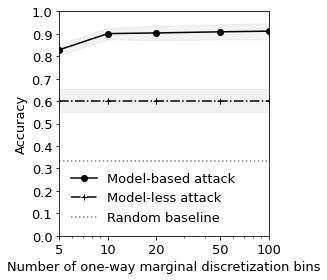

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
for i, method in enumerate(methods):
    y = mean_accs[method]
    y_min, y_max = y - std_accs[method], y + std_accs[method]
    ax.plot(nbrs_marginal_bins, y, color='k', marker=markers[i], ls=linestyles[i], label=labels[i])
    ax.fill_between(nbrs_marginal_bins, y_min, y_max, color='gray', alpha=0.1)
    print(method, ', '.join([f'G={nbrs_marginal_bins[g]}: {y[g]:.1%}' for g in range(len(y))]))
ax.axhline(y=1/3, ls=':', color='gray', label='Random baseline')
ax.tick_params(axis='both', labelsize=13)
ax.set_xscale('log')
ax.set_xlim(5, 100)
ax.set_xlabel('Number of one-way marginal discretization bins', fontsize=13)
ax.set_xticks([5, 10, 20, 50, 100])
ax.set_xticklabels(['5', '10', '20', '50', '100'])
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.savefig('../../plots/incr_nbr_marginal_bins.pdf', bbox_inches='tight')
plt.savefig('../../plots/incr_nbr_marginal_bins.png', bbox_inches='tight')
plt.show()
plt.close()